In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import MyDataset as Data
import EntropyRateSuperpixel as ERS
import SLIGbased as SNIC
import SPSbased as SPS

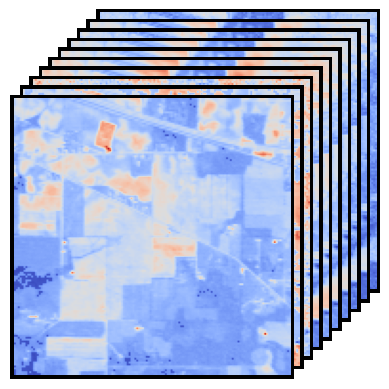

In [2]:
N,M,B = Data.IndianPines["shape"]
H = 10
D = 5

indices = np.zeros(B, dtype=int)
indices[:H]=1
np.random.shuffle(indices)
imgs = [Data.IndianPines["data"][:,:, b] for b in range(B) if indices[b]==1]

fig, ax = plt.subplots()
border_width = 2
for b in range(len(imgs)):
    d = D * (H-1-b)
    ax.imshow(np.zeros((N+2*border_width,M+2*border_width)),
              extent = (d-border_width,d+N+border_width, d-border_width,d+M+border_width),
              cmap = "gray")
    ax.imshow(imgs[len(imgs)-b-1],
              extent=(d,d+N, d,d+M),
              cmap = "coolwarm")


ax.set_xlim(0-border_width, D*(H-1) +N +border_width)
ax.set_ylim(0-border_width, D*(H-1) +M +border_width)
plt.axis("off")
plt.show()

(610, 340, 103)


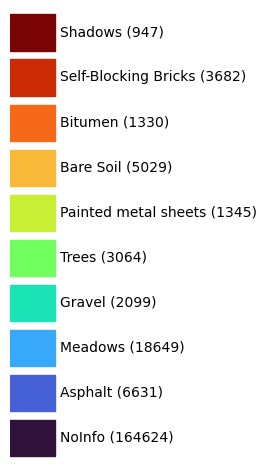

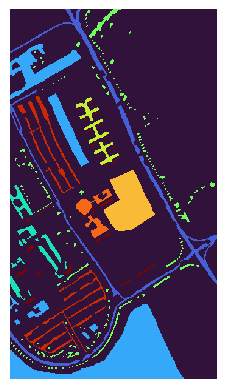

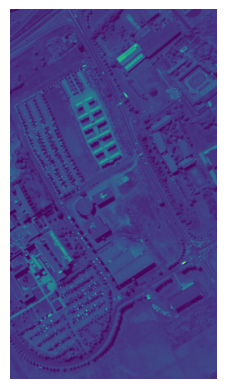

In [105]:
usedDataset = Data.PaviaUniversity
print(usedDataset["shape"])

cmap_name = "turbo"

norm = plt.Normalize(vmin=min(usedDataset["labels"]), vmax=max(usedDataset["labels"]))
cmap = mpl.cm.get_cmap(cmap_name)
fig,ax = plt.subplots()
ax.axis("off")

rect_height = 0.8
y_padding = (1 - rect_height) / 2

i = 0
for key, (name, list) in usedDataset["class"].items():
    y = i + y_padding
    color = cmap(norm(key))
    rect = mpl.patches.Rectangle((0,y), 1, rect_height, color=color)
    ax.add_patch(rect)
    ax.text(1.1, i+0.5, f"{name} ({len(list)})", va='center', fontsize=10)
    i +=1

ax.set_xlim(0, 3)
ax.set_ylim(0, i)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

plt.imshow(usedDataset["gt"], cmap=cmap_name, interpolation="none")
plt.axis("off")
plt.show()

plt.imshow(np.average(usedDataset["data"], axis=2))
plt.axis("off")
plt.show()

# Time serie 

In [2]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter

N,M,B = usedDataset["shape"]
trainData = Data.standardize_data(usedDataset["data"])

### Compute SPs

In [3]:
SPs = [pixels for key,(name, pixels) in usedDataset["class"].items()]
K = len(SPs)

In [4]:
class Graph:
    def __init__(self, n):
        self.n = n
        self.edges = [set() for _ in range(n)]

    def add_edge(self, u, v):
        self.edges[u].add(v)
        self.edges[v].add(u)

    def composante_connexe(self):
        cc = [-1 for _ in range(self.n)]

        def parcour(cc_id, todo:list):
            while len(todo)!=0:
                u = todo.pop(0)
                if cc[u]==-1:
                    cc[u] = cc_id
                    todo = todo + list(self.edges[u])
                else:   
                    todo = todo

        cc_id = -1
        for i in range(self.n):
            if cc[i]==-1:
                cc_id += 1
                parcour(cc_id, [i])
        return cc
    
graph = Graph(N*M)
maxi = max(N,M)
for i in range(N):
    for j in range(M):
        u = i*maxi + j

        if i+1<N and usedDataset["gt"][i,j]==usedDataset["gt"][i+1,j]:
            graph.add_edge(u, (i+1)*maxi + j)
        if j+1<M and usedDataset["gt"][i,j]==usedDataset["gt"][i,j+1]:
            graph.add_edge(u, i*maxi + j+1)

cc = graph.composante_connexe()
K = max(cc)+1
SPs = [[] for _ in range(K)]
img = np.zeros((N,M), dtype=int)

for i in range(N):
    for j in range(M):
        u = i*maxi + j
        img[i,j] = cc[u]
        SPs[cc[u]].append((i,j))


#plt.imshow(img)

K = len(SPs)

17


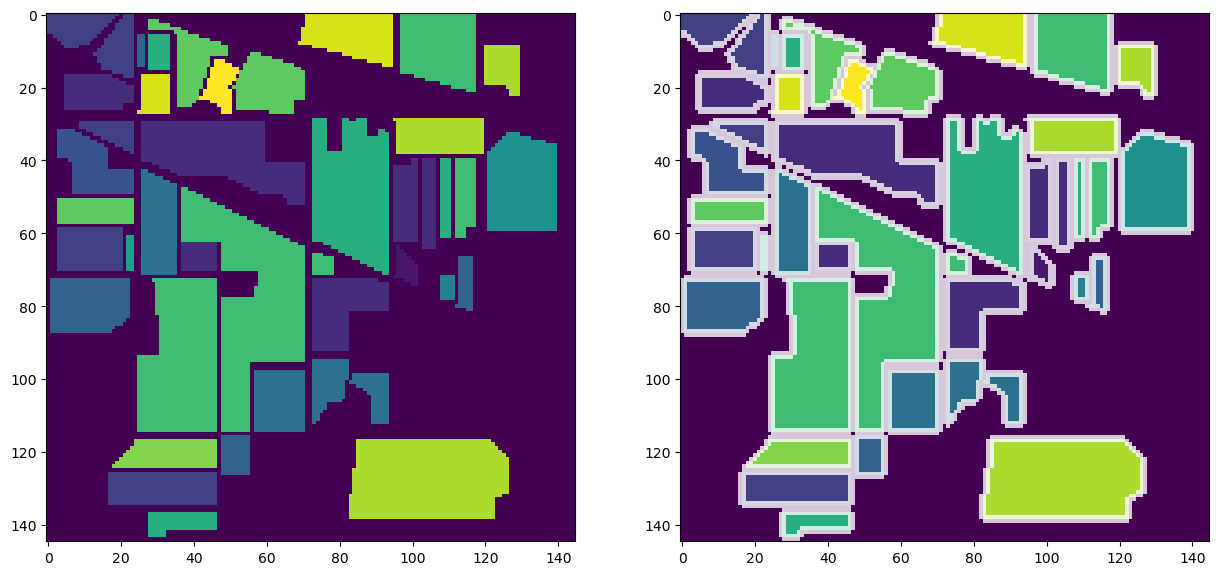

In [8]:
print(len(SPs))
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(usedDataset["gt"])
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200]))
plt.show()

### Analysis

Grass-pasture


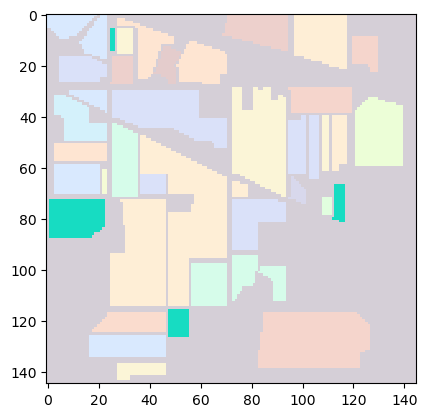

In [31]:
k1 = 11
k2 = 6
k3 = 15
ks = [k1, k2, k3]
ks = [5]
#ks = [i for i in range(len(SPs))]

for k in ks:
    print(usedDataset["class"][k][0])

cmap = mpl.colormaps["turbo"]
colors = cmap(np.linspace(0, 1, len(usedDataset["class"])))
gt_hide = np.zeros((N,M,4))
for i in range(N):
    for j in range(M):
        color = colors[usedDataset["gt"][i,j]]
        color[3] = .2
        gt_hide[i,j] = color
for k in ks:
    SP = SPs[k]
    for x,y in SP:
        color = gt_hide[x,y]
        color[3] = 1.0
        gt_hide[x,y] = color


plt.imshow(gt_hide, cmap="turbo", interpolation="none")
#plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [SPs[k1]], color=[255,0,0,255]))
#plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [SPs[k2]], color=[255,255,0,255]))
#plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [SPs[k3]], color=[0,0,255,255]))
plt.show()

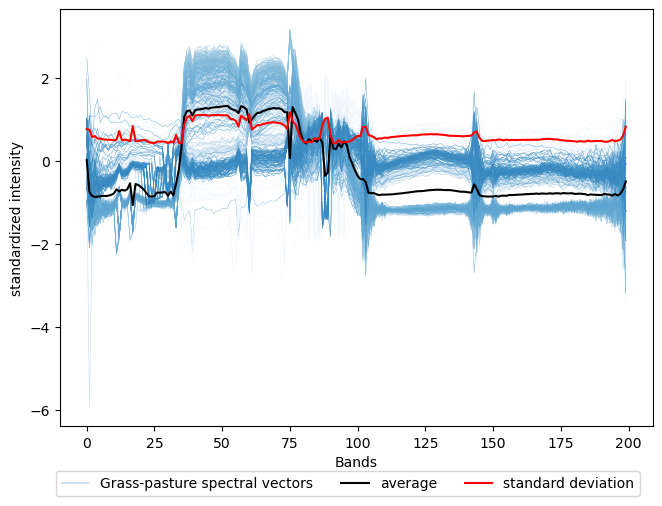

In [32]:
fig, ax = plt.subplots(1,1)

Bs = [i for i in range(B)]

SP = SPs[5]
TS = np.array([trainData[x,y] for x,y in SP])

cmap = mpl.colormaps["Blues"]
colors = cmap(np.linspace(0, 1, int(len(SP)*1.5)))
colors = list(colors)
colors.reverse()

plt.plot(Bs, TS[0], "-", linewidth=0.3, label=usedDataset["class"][k][0] + " spectral vectors")
for i in range(len(SP)):
    plt.plot(Bs, TS[i], "-", linewidth=0.3, color=colors[len(colors)-i-1])

plt.plot(Bs, np.average(TS, axis=0), "-", color="black", label="average")
plt.plot(Bs, np.std(TS, axis=0), "-", color="red", label="standard deviation")


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.06))

plt.tight_layout()
plt.subplots_adjust(left=0.05)  
plt.subplots_adjust(bottom=0.10)
plt.ylabel("standardized intensity")
plt.xlabel("Bands")
plt.show()


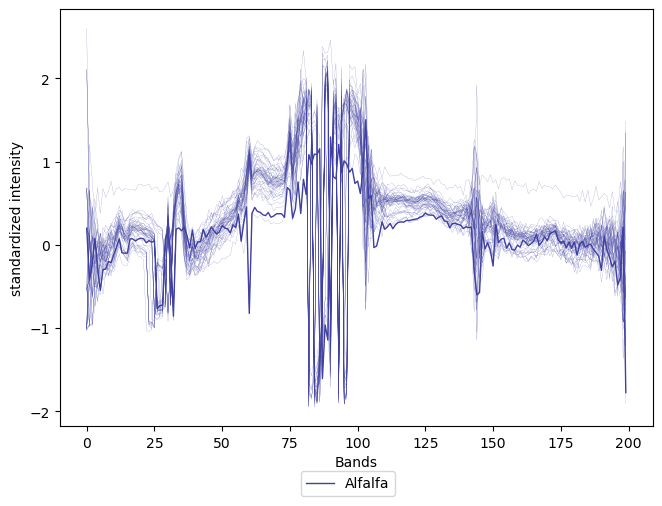

In [ ]:
fig, ax = plt.subplots(1,1)

cmap = mpl.colormaps["turbo"]
colors = cmap(np.linspace(0, 1, len(usedDataset["class"])))
Bs = [i for i in range(B)]
for k in ks:
    SP = SPs[k]

    x,y = SP[0]
    color = colors[usedDataset["gt"][x,y]]
    plt.plot(Bs, trainData[x,y], "-", linewidth=1, color=color,
                label = usedDataset["class"][usedDataset["gt"][x,y]][0])
    for x,y in SP:
        plt.plot(Bs, trainData[x,y], "-", linewidth=0.1, color=color)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.06))

plt.tight_layout()
plt.subplots_adjust(left=0.05)  
plt.subplots_adjust(bottom=0.10)
plt.ylabel("standardized intensity")
plt.xlabel("Bands")
plt.show()


# SNIC seeds

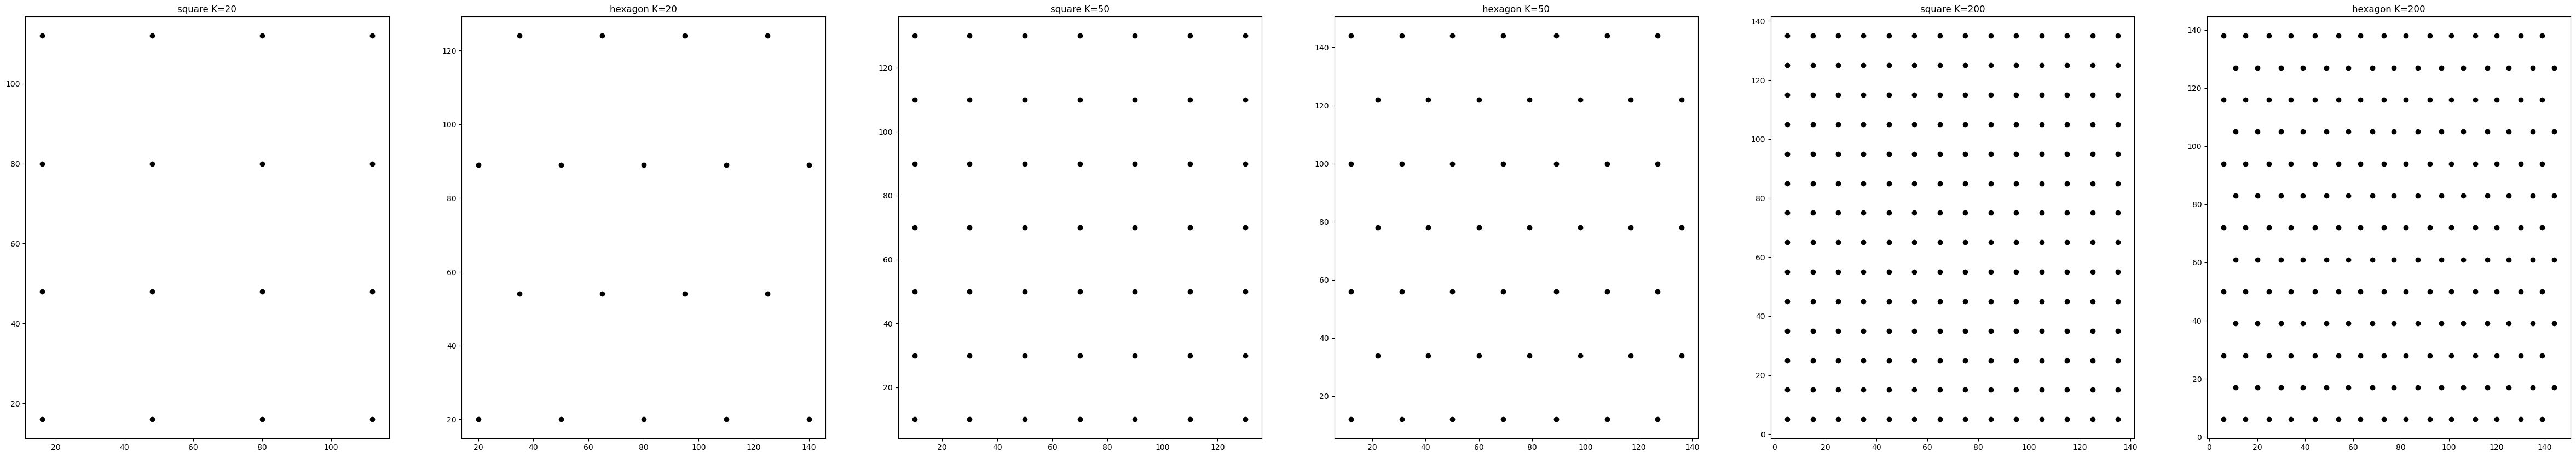

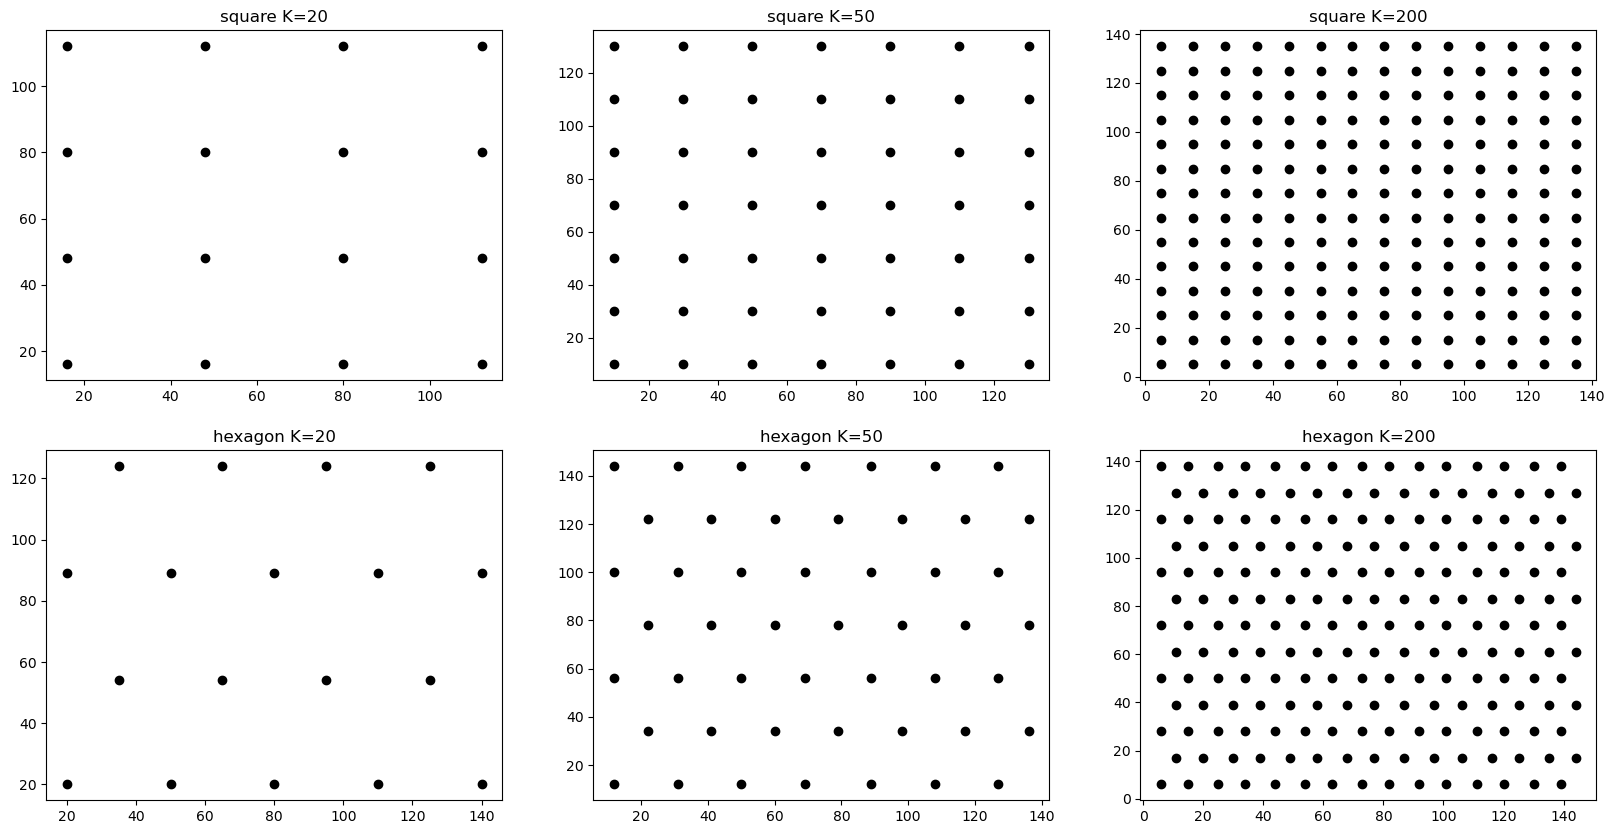

In [27]:
usedDataset = Data.IndianPines
N,M,B = usedDataset["shape"]

Ks = [20, 50, 200]
fig, axs = plt.subplots(1, 2*len(Ks), figsize=(60,10))

for j in range(len(Ks)):
    for i,fun in enumerate([SNIC.find_square_seeds, SNIC.find_hexagonal_seeds]):
    
    #plt.plot([0,N], [0,M], "o", color="white")
        _, kx, ky = fun(N,M,Ks[j])
        axs[j*2 + i].plot(kx, ky, "o", color="black")
        axs[j*2 + i].set_title(["square", "hexagon"][i] + " K=" + str(Ks[j]))

plt.show()


Ks = [20, 50, 200]
fig, axs = plt.subplots(2, len(Ks), figsize=(20,10))

for j in range(len(Ks)):
    for i,fun in enumerate([SNIC.find_square_seeds, SNIC.find_hexagonal_seeds]):
    
    #plt.plot([0,N], [0,M], "o", color="white")
        _, kx, ky = fun(N,M,Ks[j])
        axs[i,j].plot(kx, ky, "o", color="black")
        axs[i,j].set_title(["square", "hexagon"][i] + " K=" + str(Ks[j]))
plt.show()


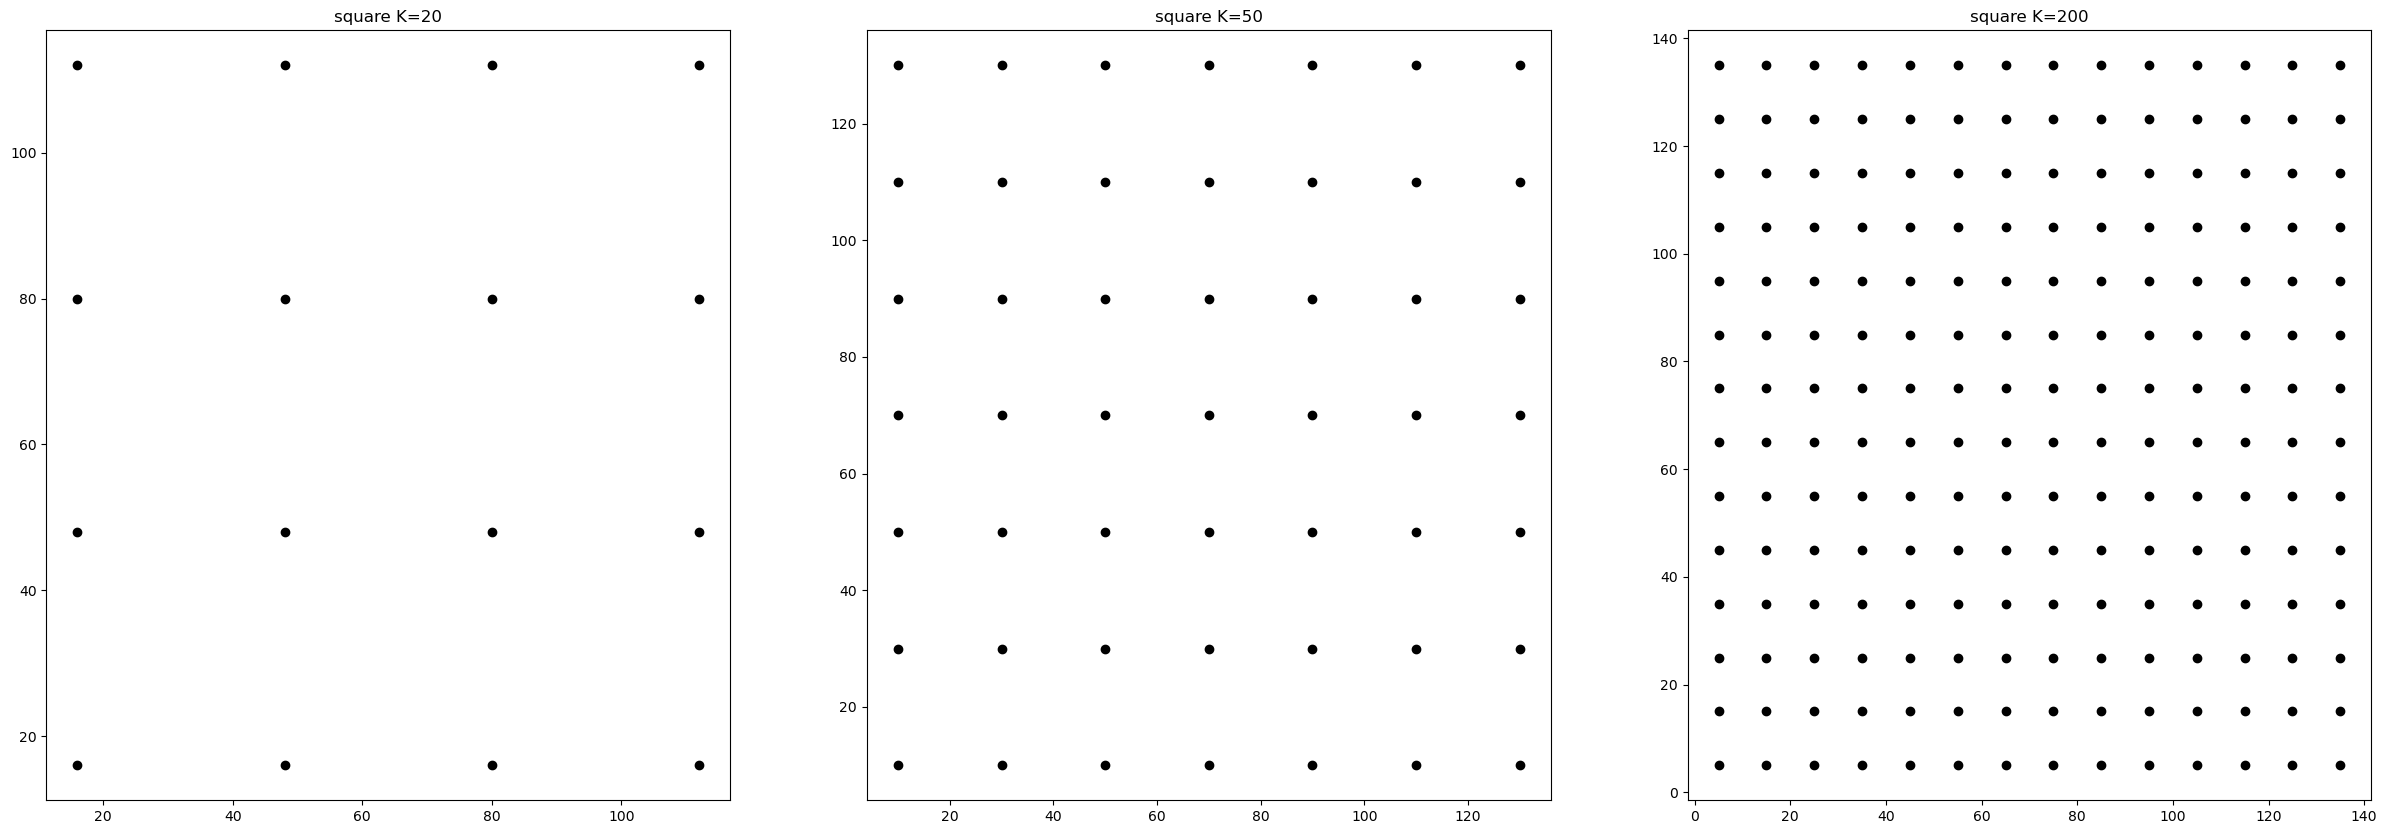

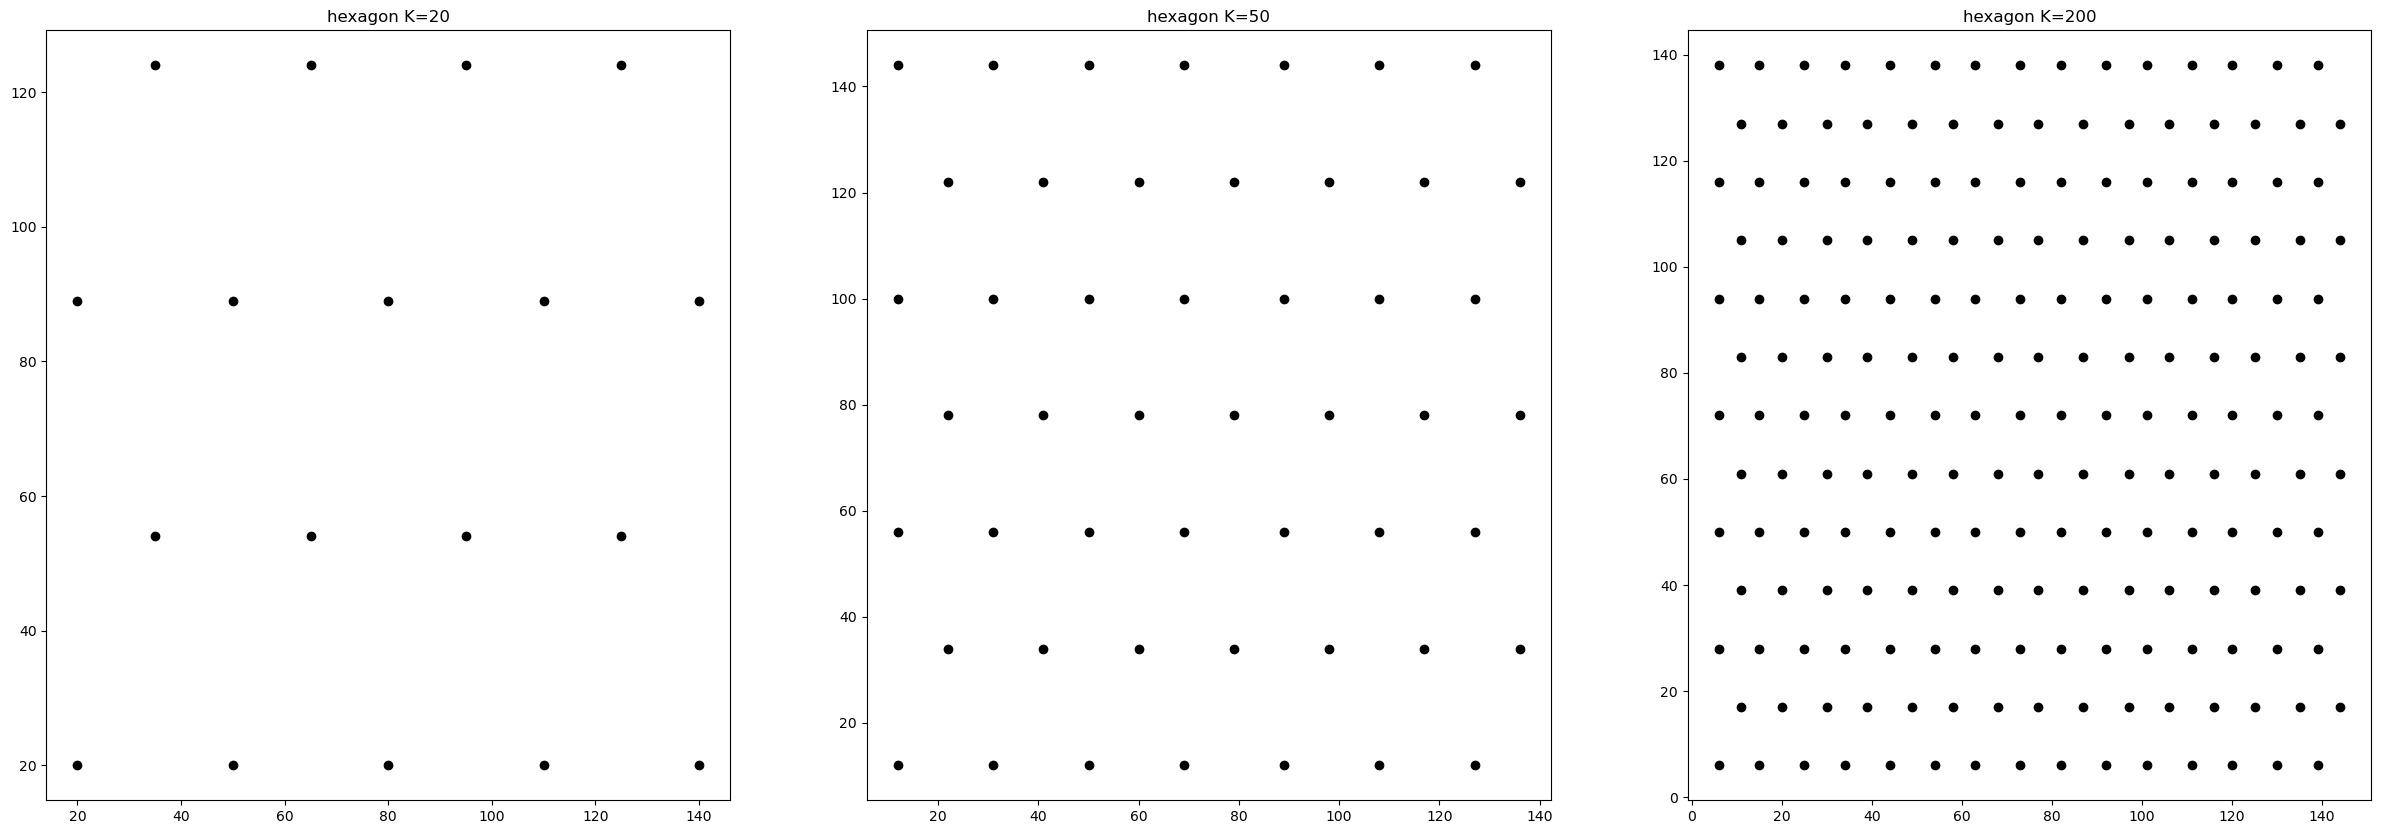

In [51]:
def dist(kx,ky, i,j):
    return np.sqrt( (kx[i]-kx[j])**2 + (ky[i]-ky[j])**2)

def draw_square(axs,id,kx,ky, color="red"):
    r = dist(kx,ky,0,1)
    for i in range(len(kx)):
        for j in range(i+1, len(kx)):
            r = min(r, dist(kx,ky,i,j))
    r = r/2
    for k in range(len(kx)):
        for x1,x2,y1,y2 in [(-r,r,-r,-r), (-r,r,r,r), (-r,-r,-r,r), (r,r,-r,r)]:
            axs[id].plot([kx[k]+x1, kx[k]+x2], [ky[k]+y1,ky[k]+y2], color=color)

def draw_hexagon(axs,id,kx,ky, color="red"):
    r = dist(kx,ky,0,1)
    for i in range(len(kx)):
        for j in range(i+1, len(kx)):
            r = min(r, dist(kx,ky,i,j))
    #r = r/2 #2*r/np.sqrt(3)
    for k in range(len(kx)):
        x,y = kx[k], ky[k]
        points = [
            (x + r,        y),
            (x + r/2,      y + np.sqrt(3)*r/2),
            (x - r/2,      y + np.sqrt(3)*r/2),
            (x - r,        y),
            (x - r/2,      y - np.sqrt(3)*r/2),
            (x + r/2,      y - np.sqrt(3)*r/2),
        ]
        for i in range(len(points)):
            axs[id].plot([points[i%len(points)][0], points[(i+1)%len(points)][0]],
                         [points[i%len(points)][1], points[(i+1)%len(points)][1]],"-", color=color)
            




Ks = [20, 50, 200]
for i,fun in enumerate([SNIC.find_square_seeds, SNIC.find_hexagonal_seeds]):
    fig, axs = plt.subplots(1, len(Ks), figsize=(30,10))

    for j in range(len(Ks)):
        _, kx, ky = fun(N,M,Ks[j])
        axs[j].plot(kx, ky, "o", color="black")
        axs[j].set_title(["square", "hexagon"][i] + " K=" + str(Ks[j]))
        #[draw_square, draw_hexagon][i](axs,j,kx,ky, color="red")
    
    plt.show()

# SPS

In [115]:
usedDataset = Data.IndianPines
trainData = Data.normalized_data(usedDataset["data"])
N,M,B = usedDataset["shape"]

In [127]:
K = 100
info = SPS.computeMergeBasedInfo(trainData, n_component=0, method="SNIC")
SPs = SPS.mergedBasedSegmentation(trainData, K, infos=info,
                                    usedVarFun=SPS.stdFtestnorm1, dist=(2,""),
                                    n_component=0, weighted_avg=True)

(-0.5, 144.5, 144.5, -0.5)

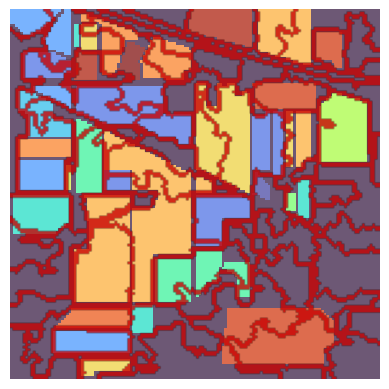

In [ ]:
plt.imshow(usedDataset["gt"], cmap="turbo", interpolation="none")

mask = np.ones((N,M,4))
mask[:,:,3] = .3
plt.imshow(mask)

plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[200,0,0, 200], exterior=False))

plt.axis("off")


In [128]:
neighboors = [set() for _ in range(len(SPs))]

pixelToSP = np.zeros((N,M), dtype=int)
for k,SP in enumerate(SPs):
    for x,y in SP:
        pixelToSP[x,y] = k
borders = ERS.find_borders(SPs, (N,M), exterior=True)
for k1 in range(len(borders)):
    for x,y in borders[k1]:
        k2 = pixelToSP[x,y]
        neighboors[k1].add(k2)

46
{40, 65, 42}


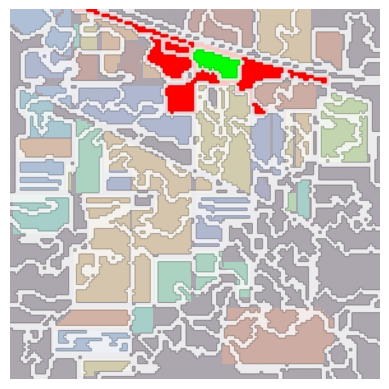

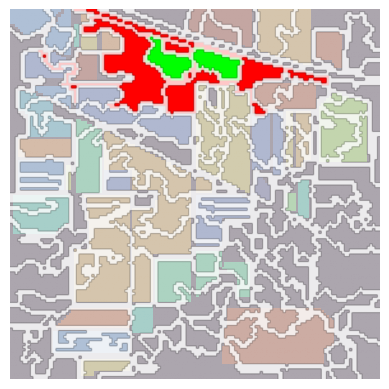

In [133]:
plt.imshow(usedDataset["gt"], cmap="turbo", interpolation="none")
mask = np.ones((N,M,4))*.8
mask[:,:,3] = .8

plt.imshow(mask)

k = pixelToSP[20,80]
print(k)
mask = np.zeros((N,M, 4), dtype=int)
for x,y in SPs[k]:
    mask[x,y] = [0,255,0,255]

print(neighboors[k])
for n in neighboors[k]:
    for x,y in SPs[n]:
        mask[x,y] = [255,0,0,255]


plt.imshow(mask)
plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255, 200], exterior=False))
plt.axis("off")
plt.show()



plt.imshow(usedDataset["gt"], cmap="turbo", interpolation="none")
mask = np.ones((N,M,4))*.8
mask[:,:,3] = .8
plt.imshow(mask)

mask = np.zeros((N,M, 4), dtype=int)
for n in neighboors[k].union(neighboors[40]):
    for x,y in SPs[n]:
        mask[x,y] = [255,0,0,255]


for x,y in SPs[k]:
    mask[x,y] = [0,255,0,255]
for x,y in SPs[40]:
    mask[x,y] = [0,255,0,255]


plt.imshow(mask)
plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255, 200], exterior=False))
plt.axis("off")
plt.show()

# CWA

In [158]:
usedDataset = Data.IndianPines
trainData = Data.normalized_data(usedDataset["data"])
N,M,B = usedDataset["shape"]

K = 30
info = SPS.computeMergeBasedInfo(trainData, n_component=0, method="SNIC")
SPs = SPS.mergedBasedSegmentation(trainData, K, infos=info,
                                    usedVarFun=SPS.stdFtestnorm1, dist=(2,""),
                                    n_component=0, weighted_avg=True)

pixelToSP = np.zeros((N,M), dtype=int)
for k,SP in enumerate(SPs):
    for x,y in SP:
        pixelToSP[x,y] = k

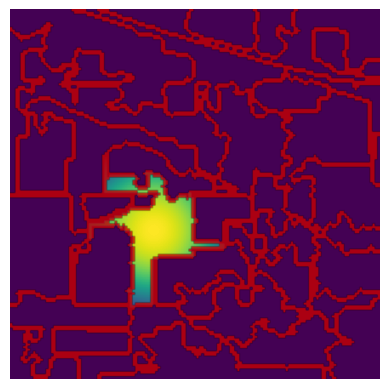

In [166]:
#plt.imshow(usedDataset["gt"], cmap="turbo", interpolation="none")
k = pixelToSP[80, 50]

def dist_squared(c1, c2):
    return (c1[0]-c2[0])**2 + (c1[1]-c2[1])**2
center = np.average(SPs[k], axis=0)
dtc = np.array([dist_squared(coor, center) for coor in SPs[k]])


x = max(dtc)-dtc
norm = np.linalg.norm(x)
idtc = x/norm


mask = np.zeros((N,M))
for i in range(len(SPs[k])):
    x,y = SPs[k][i]
    mask[x,y] = idtc[i]
plt.imshow(mask)


plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[200,0,0, 200], exterior=False))
plt.axis("off")
plt.show()